In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
dtypes = {
    "Cause of Death": "category",
    "Year": int,
    "Month": "category",
    "Age group": "category",
    "Vaccination status": "category",
}

cols = [
    "Cause of Death",
    "Year",
    "Month",
    "Age group",
    "Vaccination status",
    "Count of Deaths",
]

def conv_deaths(n):
    if n == "<3":
        return 2
    return int(n)

In [3]:
df = pd.read_csv(
    "table8.tsv",
    sep="\t",
    skiprows=3,
    header=0,
    dtype=dtypes,
    usecols=cols,
    converters={"Count of Deaths": conv_deaths}
)
df.head(5)

,Cause of Death,Year,Month,Age group,Vaccination status,Count of Deaths
0,All causes,2021,January,10-39,Unvaccinated,969
1,All causes,2021,January,10-39,Ever vaccinated,17
2,All causes,2021,January,40-49,Unvaccinated,1574
3,All causes,2021,January,40-49,Ever vaccinated,24
4,All causes,2021,January,50-59,Unvaccinated,3954


In [4]:
df.columns

Index(['Cause of Death', 'Year', 'Month', 'Age group', 'Vaccination status',
       'Count of Deaths'],
      dtype='object')

In [5]:
df.dtypes

Cause of Death        category
Year                     int64
Month                 category
Age group             category
Vaccination status    category
Count of Deaths          int64
dtype: object

In [6]:
group_cols = [
    "Vaccination status",
    "Year",
    "Month"
]

dfa = (df[df["Cause of Death"] == "Deaths involving COVID-19"]
      .drop(columns="Cause of Death")
      .groupby(group_cols)
      .agg({"Count of Deaths": "sum"})
      .reset_index())

dfa.insert(
    0,
    "Date",
    value=dfa["Month"].astype(str) + " " + dfa["Year"].astype(str)
)
dfa["Date"] = pd.to_datetime(dfa["Date"])

dfa.drop(columns=["Year", "Month"], inplace=True)
dfa.head(5)

,Date,Vaccination status,Count of Deaths
0,2021-04-01,Ever vaccinated,595
1,2021-08-01,Ever vaccinated,1911
2,2021-12-01,Ever vaccinated,2320
3,2021-02-01,Ever vaccinated,5543
4,2021-01-01,Ever vaccinated,3951


In [7]:
dfv = dfa[dfa["Vaccination status"] == "Ever vaccinated"].drop(columns="Vaccination status")
dfu = dfa[dfa["Vaccination status"] != "Ever vaccinated"].drop(columns="Vaccination status")
dfv.head(3)

,Date,Count of Deaths
0,2021-04-01,595
1,2021-08-01,1911
2,2021-12-01,2320


In [8]:
dfm = dfv.merge(
    dfu,
    on=["Date"],
    suffixes=(", Vacc.", ", Unvac.")
)
dfm.head(3)

,Date,"Count of Deaths, Vacc.","Count of Deaths, Unvac."
0,2021-04-01,595,308
1,2021-08-01,1911,849
2,2021-12-01,2320,1017


In [9]:
sns.set()
sns.set_style("whitegrid")

In [10]:
df19 = (
    dfm[(dfm["Date"] >= "2022-01-01") &
        (dfm["Date"] < "2022-06-01")]
        .sort_values("Date")
        .reset_index(drop=True)
)

df19["% of Deaths, Unvac."] = df19["Count of Deaths, Unvac."] * 100 / (df19["Count of Deaths, Unvac."] + df19["Count of Deaths, Vacc."])

df19["% of Deaths, Vacc."] = df19["Count of Deaths, Vacc."] * 100 / (df19["Count of Deaths, Unvac."] + df19["Count of Deaths, Vacc."])

df19

,Date,"Count of Deaths, Vacc.","Count of Deaths, Unvac.","% of Deaths, Unvac.","% of Deaths, Vacc."
0,2022-01-01,4492,1017,18.460701,81.539299
1,2022-02-01,2763,371,11.837907,88.162093
2,2022-03-01,3003,287,8.723404,91.276596
3,2022-04-01,3783,275,6.776737,93.223263
4,2022-05-01,1439,120,7.697242,92.302758


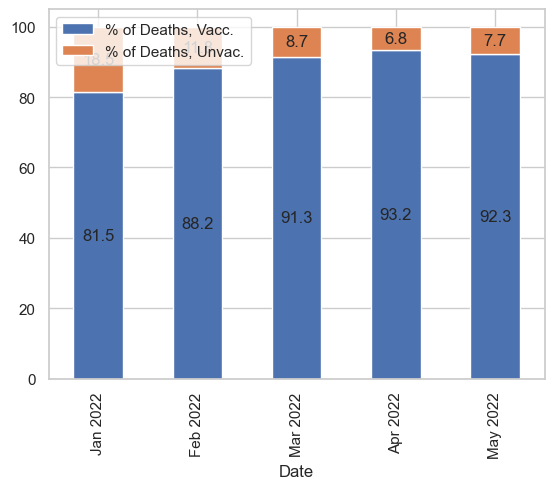

In [11]:
ax = df19.plot.bar(
    x='Date',
    y=["% of Deaths, Vacc.", "% of Deaths, Unvac."],
    stacked=True
)

ax.set_xticklabels(df19["Date"].dt.strftime("%b %Y"))
ax.bar_label(ax.containers[0], label_type="center", fmt="%.1f")
ax.bar_label(ax.containers[1], label_type="center", fmt="%.1f")

plt.show()

In [12]:
import dask.dataframe as dd

ovid_cols = [
    "iso_code",
    "date",
    "people_vaccinated",
    "population",
]

ddf = dd.read_csv(
    "owid-covid-data.csv",
    usecols=ovid_cols,
    parse_dates=["date"],
)

owid = ddf[
    (ddf["iso_code"] == "GBR") &
    (ddf["date"].dt.day == 1)].compute()

owid.drop("iso_code", axis=1, inplace=True)
owid["perc_vacc"] = owid["people_vaccinated"] * 100 / owid["population"]
owid["perc_unvac"] = 100 - owid["perc_vacc"]

owid.dtypes

date                 datetime64[ns]
people_vaccinated           float64
population                  float64
perc_vacc                   float64
perc_unvac                  float64
dtype: object

In [13]:
owid.head(3)

,date,people_vaccinated,population,perc_vacc,perc_unvac
200555,2020-02-01,NaN,67281040.0,NaN,NaN
200584,2020-03-01,NaN,67281040.0,NaN,NaN
200615,2020-04-01,NaN,67281040.0,NaN,NaN


In [14]:
owid.tail(3)

,date,people_vaccinated,population,perc_vacc,perc_unvac
201436,2022-07-01,53617742.0,67281040.0,79.692202,20.307798
201467,2022-08-01,53726268.0,67281040.0,79.853504,20.146496
201498,2022-09-01,NaN,67281040.0,NaN,NaN


In [15]:
pdata2 = owid[
    (owid["date"] >= "2022-01-01") &
    (owid["date"] < "2022-06-01")].sort_values("date").reset_index(drop=True)

pdata2

,date,people_vaccinated,population,perc_vacc,perc_unvac
0,2022-01-01,51789045.0,67281040.0,76.974204,23.025796
1,2022-02-01,52373222.0,67281040.0,77.842468,22.157532
2,2022-03-01,52640258.0,67281040.0,78.239364,21.760636
3,2022-04-01,52808470.0,67281040.0,78.489378,21.510622
4,2022-05-01,53242209.0,67281040.0,79.134046,20.865954


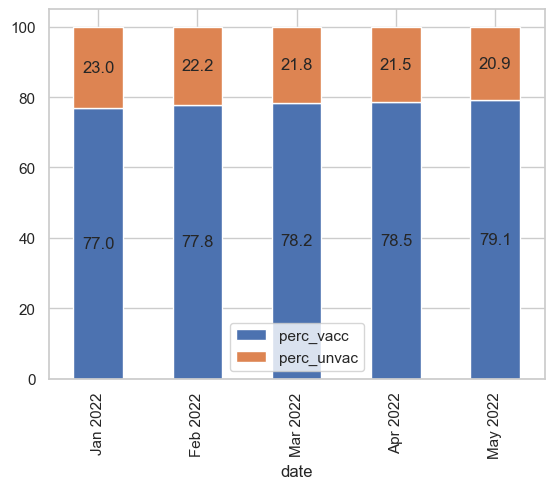

In [16]:
ax2 = pdata2.plot.bar(
    x="date",
    y=["perc_vacc", "perc_unvac"],
    stacked=True
)

ax2.set_xticklabels(pdata2["date"].dt.strftime("%b %Y"))
ax2.bar_label(ax2.containers[0], label_type="center", fmt="%.1f")
ax2.bar_label(ax2.containers[1], label_type="center", fmt="%.1f")

plt.show()

In [17]:
dfr = df19[["Date", "Count of Deaths, Vacc.", "Count of Deaths, Unvac."]].merge(
    pdata2[["date", "people_vaccinated", "population"]],
    left_on="Date",
    right_on="date",
).drop(columns="Date")

dfr.rename(columns={
        "Count of Deaths, Vacc.": "deaths_vacc",
        "Count of Deaths, Unvac.": "deaths_unvac",
    },
    inplace=True
)
dfr["deaths_per100k_vacc"] = dfr["deaths_vacc"] * 100000 / dfr["people_vaccinated"]
dfr["deaths_per100k_unvac"] = dfr["deaths_unvac"] * 100000 / (dfr["population"] - dfr["people_vaccinated"])

dfr[["date", "deaths_per100k_vacc", "deaths_per100k_unvac"]]

,date,deaths_per100k_vacc,deaths_per100k_unvac
0,2022-01-01,8.673649,6.564681
1,2022-02-01,5.275597,2.488627
2,2022-03-01,5.704759,1.960278
3,2022-04-01,7.163624,1.900146
4,2022-05-01,2.702743,0.854772


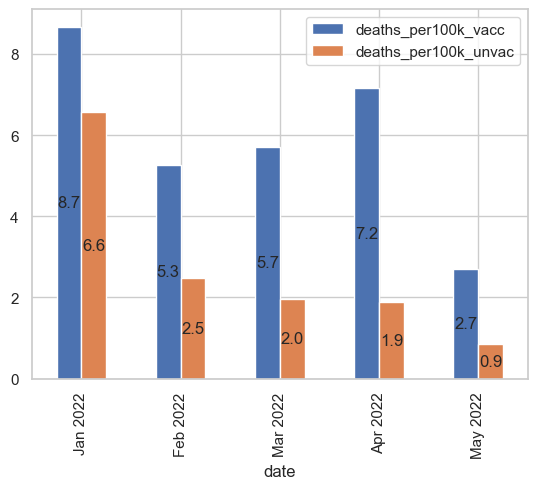

In [18]:
ax3 = dfr.plot.bar(
    x="date",
    y=["deaths_per100k_vacc", "deaths_per100k_unvac"],
)

ax3.set_xticklabels(dfr["date"].dt.strftime("%b %Y"))
ax3.bar_label(ax3.containers[0], label_type="center", fmt="%.1f")
ax3.bar_label(ax3.containers[1], label_type="center", fmt="%.1f")

plt.show()

In [255]:
t1_dtypes = {
    "Cause of Death": "category",
    "Year": int,
    "Month": "category",
    "Vaccination status": "category",
    "Noted as Unreliable": "category"
}

t1_cols = [
    "Cause of Death",
    "Year",
    "Month",
    "Vaccination status",
    "Age-standardised mortality rate / 100,000 person-years",
    "Noted as Unreliable"
]

def conv_rate(n):
    if n == 'x':
        return 0
    return float(n)

In [264]:
t1 = pd.read_csv(
    "table1.tsv",
    sep="\t",
    skiprows=3,
    header=0,
    dtype=t1_dtypes,
    usecols=t1_cols,
    converters={"Age-standardised mortality rate / 100,000 person-years": conv_rate}
)

t1 = t1[(t1["Cause of Death"] == "Deaths involving COVID-19") &
        (t1["Vaccination status"].isin(["Ever vaccinated", "Unvaccinated"])) &
        (t1["Noted as Unreliable"] != "u")]

t1.insert(
    0,
    "date",
    value=t1["Month"].astype(str) + " " + t1["Year"].astype(str)
)
t1["date"] = pd.to_datetime(t1["date"])

t1.drop(columns=["Year", "Month", "Cause of Death", "Noted as Unreliable"], inplace=True)

t1.rename(
    columns={
        "Vaccination status": "vacc_status",
        "Age-standardised mortality rate / 100,000 person-years": "mort_rate"
    },
    inplace=True
)

t1

,date,vacc_status,mort_rate
153,2021-01-01,Unvaccinated,1187.2
161,2021-01-01,Ever vaccinated,672.0
162,2021-02-01,Unvaccinated,2174.3
170,2021-02-01,Ever vaccinated,183.7
171,2021-03-01,Unvaccinated,591.9
179,2021-03-01,Ever vaccinated,53.7
180,2021-04-01,Unvaccinated,145.8
188,2021-04-01,Ever vaccinated,15.7
189,2021-05-01,Unvaccinated,45.5
197,2021-05-01,Ever vaccinated,6.2


In [275]:
t1p = t1.pivot(
    index="date",
    columns=["vacc_status"]
).reset_index()

In [277]:
t1p

date    mort_rate                
vacc_status            Unvaccinated Ever vaccinated
0           2021-01-01       1187.2           672.0
1           2021-02-01       2174.3           183.7
2           2021-03-01        591.9            53.7
3           2021-04-01        145.8            15.7
4           2021-05-01         45.5             6.2
5           2021-06-01         55.6             6.7
6           2021-07-01        218.2            24.1
7           2021-08-01        404.2            47.2
8           2021-09-01        367.8            65.7
9           2021-10-01        322.3            67.0
10          2021-11-01        421.3            69.7
11          2021-12-01        520.5            56.3
12          2022-01-01        584.6           109.8
13          2022-02-01        258.7            75.6
14          2022-03-01        183.5            74.2
15          2022-04-01        204.7            96.5
16          2022-05-01         77.6            35.5

In [281]:
t1p.columns = [', '.join([x.lower() for x in c if x]) for c in t1p]
t1p

,date,"mort_rate, unvaccinated","mort_rate, ever vaccinated"
0,2021-01-01,1187.2,672.0
1,2021-02-01,2174.3,183.7
2,2021-03-01,591.9,53.7
3,2021-04-01,145.8,15.7
4,2021-05-01,45.5,6.2
5,2021-06-01,55.6,6.7
6,2021-07-01,218.2,24.1
7,2021-08-01,404.2,47.2
8,2021-09-01,367.8,65.7
9,2021-10-01,322.3,67.0


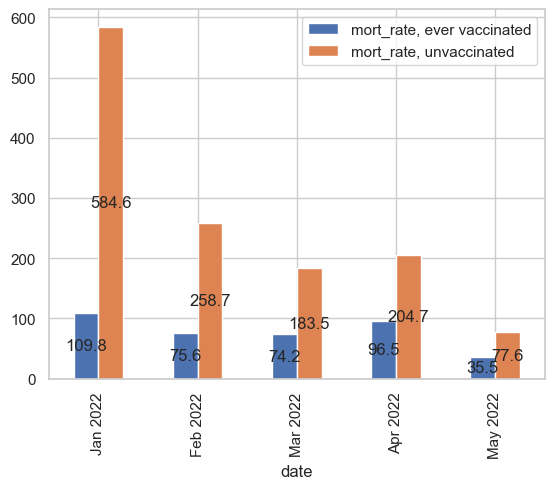

In [285]:
t1_data = t1p[(t1p["date"] >= "2022-01-01") &
             (t1p["date"] < "2022-06-01")]

ax4 = t1_data.plot.bar(
    x="date",
    y=["mort_rate, ever vaccinated", "mort_rate, unvaccinated"],
)

ax4.set_xticklabels(t1_data["date"].dt.strftime("%b %Y"))
ax4.bar_label(ax4.containers[0], label_type="center", fmt="%.1f")
ax4.bar_label(ax4.containers[1], label_type="center", fmt="%.1f")

plt.show()

### Total deaths by vaccination status

In [20]:
t6_cols = [
    "Age group",
    "Vaccination status",
    "Count of deaths involving COVID-19",
]

t6_dtypes = {
    "Age group": "category",
    "Vaccination status": "category",
    "Count of deaths involving COVID-19": int,
}

In [21]:
t6 = pd.read_csv(
    "table6.tsv",
    sep="\t",
    skiprows=3,
    header=0,
    dtype=t6_dtypes,
    usecols=t6_cols,
)
t6

,Age group,Vaccination status,Count of deaths involving COVID-19
0,10-14,Unvaccinated,9
1,10-14,"First dose, less than 21 days ago",2
2,10-14,"First dose, at least 21 days ago",0
3,10-14,"Second dose, less than 21 days ago",0
4,10-14,"Second dose, between 21 days and 6 months ago",0
...,...,...,...
131,90+,"Second dose, less than 21 days ago",50
132,90+,"Second dose, between 21 days and 6 months ago",937
133,90+,"Second dose, at least 6 months ago",1364
134,90+,"Third dose or booster, less than 21 days ago",118


In [34]:
t6_data = t6.pivot(
    index="Age group",
    columns=["Vaccination status"]
).reset_index()
t6_data

Age group Count of deaths involving COVID-19  \
Vaccination status             First dose, at least 21 days ago   
0                      10-14                                  0   
1                      15-19                                  2   
2                      20-24                                  5   
3                      25-29                                  5   
4                      30-34                                  9   
5                      35-39                                 15   
6                      40-44                                 13   
7                      45-49                                 39   
8                      50-54                                 66   
9                      55-59                                113   
10                     60-64                                176   
11                     65-69                                242   
12                     70-74                                413   
13                     75-79                                810   
14                     80-84                               1414   
15                     85-89                               1797   
16                       90+                               2151   

                                                      \
Vaccination status First dose, less than 21 days ago   
0                                                  2   
1                                                  0   
2                                                  1   
3                                                  2   
4                                                  3   
5                                                  9   
6                                                  3   
7                                                 13   
8                                                 21   
9                                                 44   
10                                                67   
11                                               122   
12                                               235   
13                                               467   
14                                               803   
15                                               961   
16                                              1284   

                                                       \
Vaccination status Second dose, at least 6 months ago   
0                                                   0   
1                                                   0   
2                                                   2   
3                                                   3   
4                                                  13   
5                                                  11   
6                                                  39   
7                                                  60   
8                                                 110   
9                                                 181   
10                                                290   
11                                                436   
12                                                673   
13                                                928   
14                                               1228   
15                                               1326   
16                                               1364   

                                                                  \
Vaccination status Second dose, between 21 days and 6 months ago   
0                                                              0   
1                                                              2   
2                                                              4   
3                                                             11   
4                                                             10   
5                                                             24   
6                                                   

In [40]:
t6_data.columns = [c[1] or c[0] for c in t6_data.columns]
t6_data

,Age group,"First dose, at least 21 days ago","First dose, less than 21 days ago","Second dose, at least 6 months ago","Second dose, between 21 days and 6 months ago","Second dose, less than 21 days ago","Third dose or booster, at least 21 days ago","Third dose or booster, less than 21 days ago",Unvaccinated
0,10-14,0,2,0,0,0,1,0,9
1,15-19,2,0,0,2,1,1,1,24
2,20-24,5,1,2,4,0,4,0,43
3,25-29,5,2,3,11,0,5,0,68
4,30-34,9,3,13,10,0,4,1,129
5,35-39,15,9,11,24,1,10,1,238
6,40-44,13,3,39,40,0,25,1,299
7,45-49,39,13,60,65,1,39,6,597
8,50-54,66,21,110,120,0,85,5,1069
9,55-59,113,44,181,239,2,168,7,1626


In [44]:
t6_data.columns

Index(['Age group', 'First dose, at least 21 days ago',
       'First dose, less than 21 days ago',
       'Second dose, at least 6 months ago',
       'Second dose, between 21 days and 6 months ago',
       'Second dose, less than 21 days ago',
       'Third dose or booster, at least 21 days ago',
       'Third dose or booster, less than 21 days ago', 'Unvaccinated'],
      dtype='object')

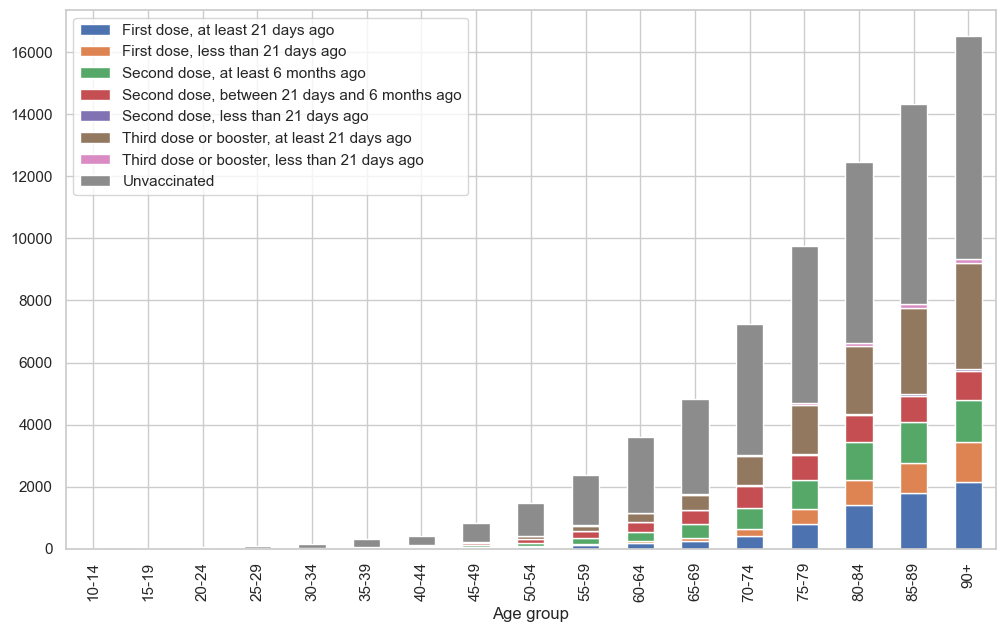

In [54]:
t6_y = [
    "First dose, at least 21 days ago",
    "First dose, less than 21 days ago",
    "Second dose, at least 6 months ago",
    "Second dose, between 21 days and 6 months ago",
    "Second dose, less than 21 days ago",
    "Third dose or booster, at least 21 days ago",
    "Third dose or booster, less than 21 days ago",
    "Unvaccinated"
]

ax6 = t6_data.plot.bar(
    x="Age group",
    y=t6_y,
    stacked=True,
    figsize=(12, 7)
)

ax6.set_xticklabels(t6_data["Age group"])

plt.show()